# Policy Gradient for Cart Pole Reinforcement Learning

- From Chapter 16 in "Handson Machine Learning with Scikit-Learn and Tensorflow"

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gym

import torch
from torch import nn, optim
from torch.autograd import Variable

%matplotlib inline

## Cart Pole from openai gym

In [2]:
env = gym.make("CartPole-v1")
env.reset()

[2017-06-15 21:04:09,709] Making new env: CartPole-v1


array([-0.01322629, -0.01979786, -0.0343556 ,  0.03389911])

## Basic Policy

In [3]:
def basic_policy(obs):
    # obs = (position, speed, angel, angel_speed)
    angel = obs[2]
    # action 0 to left 1 to right
    return 0 if angel < 0 else 1

## test basic policy
all_rewards = []
for igame in range(500):
    obs = env.reset()
    game_rewards = 0
    for step in range(1000):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        if done: break
        game_rewards += reward
    all_rewards.append(game_rewards)

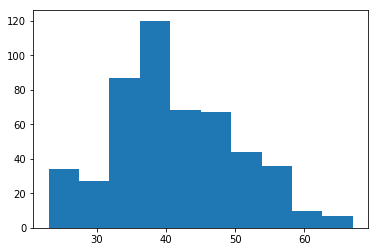

In [4]:
_ = plt.hist(all_rewards)

## Train a MLP based on Policy Gradient
- training on one observation each time?

### Model

In [5]:
class CartPoleModel(nn.Module):
    def __init__(self):
        super(CartPoleModel, self).__init__()
        self.fc1 = nn.Linear(4, 4)
        self.elu = nn.ELU()
        self.fc2 = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out = self.elu(self.fc1(x))
        logits = self.fc2(out)
        probs = self.sigmoid(logits)
        self.label = torch.multinomial(torch.cat([probs, 1-probs], dim=1), 1)

        return probs
    def output(self):
        return self.label

In [6]:
m = CartPoleModel().cuda()
x = Variable(torch.from_numpy(obs.astype(np.float32))[None, ...]).cuda()
m(x), m.output()

(Variable containing:
  0.5090
 [torch.cuda.FloatTensor of size 1x1 (GPU 0)], Variable containing:
  1
 [torch.cuda.LongTensor of size 1x1 (GPU 0)])

### Utility for Credit Assignment

In [7]:
def discount_rewards(rewards, discount_rate):
    """rewards: rewards of all steps for a single game, a list
    """
    discounted_rewards = np.empty(len(rewards),dtype=np.float32)
    accum_reward = 0
    for i in reversed(range(len(rewards))):
        accum_reward = rewards[i] + accum_reward * discount_rate
        discounted_rewards[i] = accum_reward
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    """
    all_rewards: rewards of all games for all steps, a list of list
    """
    discounted_all_rewards = [discount_rewards(rewards, discount_rate)
                             for rewards in all_rewards]
    flatten_rewards = [reward for rewards in discounted_all_rewards
                          for reward in rewards]
    reward_mean = np.mean(flatten_rewards)
    reward_std = np.std(flatten_rewards)
    normalized_rewards = [(rewards - reward_mean) / reward_std
                         for rewards in discounted_all_rewards]
    return normalized_rewards

In [8]:
discount_rewards([10, 0, -50], discount_rate=.8)

array([-22., -40., -50.], dtype=float32)

In [9]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]],
                               discount_rate=0.8)

[array([-0.28435072, -0.86597717, -1.18910301], dtype=float32),
 array([ 1.2666533 ,  1.07277775], dtype=float32)]

In [10]:
a = discount_and_normalize_rewards([[10, 0, -50], [10, 20]],
                               discount_rate=0.8)
type(float(a[0][0]))

float

## Training - method 1
- three layers loop
    - for each epoch (update parameters)
    - for each game
    - for each step in the game
- the collection of rewards will be a list of list
    - for each game
    - for each step
- the collection of gradients of be a list of list of tensor
    - for each game, each step
    - a gradient tensor
- at each iteration, the gradient will be weighted by normalized-discounted rewards, and aggregated as mean to update

In [11]:
n_epochs = 250
n_max_steps = 1000
n_games_per_update = 10
discount_rate = .95

objective = nn.BCELoss()

model = CartPoleModel().cuda()
model.train()

params = list(model.parameters())

optimizer = optim.Adam(params, lr=1e-2)



for epoch in range(n_epochs):
    
    all_gradients = []
    all_rewards = []
    
    for game in range(n_games_per_update):
        
        game_gradients = []
        game_rewards = []
        obs = env.reset()
        
        for step in range(n_max_steps):
            # train on one observation
            obs_var = Variable(torch.from_numpy(obs.astype(np.float32))[None, ...]).cuda()
            model.zero_grad()
            prob = model(obs_var)
            action = model.output().data[0][0]#.cpu().numpy()
#             action = prob.multinomial().data[0][0] # this doesnt work as expected! prob needs to be a vector!
            obs, reward, done, info = env.step(action)
            # action: 0 left 1 right, y: prob of left
            y = Variable(torch.FloatTensor([1. - action]))[None, ...].cuda()
            loss = objective(prob, y)
            loss.backward()
            gradient = [p.grad for p in params]
            game_gradients.append(gradient)
            game_rewards.append(reward)
            if done:
                break
                
        all_gradients.append(game_gradients)
        all_rewards.append(game_rewards)
    
    ## normalize and discount rewards
    normalized_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
    ## aggregate gradients
    for param in range(len(params)):
        mean_gradient = np.mean([ float(normalized_rewards[game][step])*step_gradients[param].data 
                                for game, game_gradients in enumerate(all_gradients)
                                for step, step_gradients in enumerate(game_gradients)])
#         print(mean_gradient)
        params[param].grad.data.set_(mean_gradient)
    ## optimize based on aggregated gradient
    optimizer.step()
    if epoch % 25 == 0:
        mean_reward = np.mean([np.sum(reward) for reward in all_rewards])
        print(epoch, mean_reward)

0 18.7
25 20.0
50 16.7
75 28.6
100 21.3
125 28.4
150 19.6
175 20.9
200 15.6
225 20.2


*** It didn't work very well... maybe the naive way of updating the gradient didn't work?***

## Training - method 2

Instead of computing weighted mean of gradient, we can also compute the weighted mean of loss function, and do the normal backpropagation

*** Lesson Learned ***: Try to avoid manipulate the gradient directly in pytorch, if possible, modify the loss function or use other ways.

In [12]:
%%time

n_epochs = 200
n_max_steps = 1000
n_games_per_update = 10
discount_rate = .95

objective = nn.BCELoss()

model = CartPoleModel().cuda()
model.train()


optimizer = optim.Adam(model.parameters(), lr=1e-2)



for epoch in range(n_epochs):
    
    all_losses = []
    all_rewards = []
    
    for game in range(n_games_per_update):
        
        game_losses = []
        game_rewards = []
        
        obs = env.reset()
        
        for step in range(n_max_steps):
            # train on one observation
            obs_var = Variable(torch.from_numpy(obs.astype(np.float32))[None, ...]).cuda()
            model.zero_grad()
            prob = model(obs_var)
            action = model.output().data[0][0]#.cpu().numpy()
#             action = prob.multinomial().data[0][0] # this doesn't work as expected, prob should be a softmax vector
            obs, reward, done, info = env.step(action)
            # action: 0 left 1 right, y: prob of left
            y = Variable(torch.FloatTensor([1. - action]))[None, ...].cuda()
            loss = objective(prob, y)
            game_losses.append(loss)
            game_rewards.append(reward)
            if done:
                break
                
        all_losses.append(game_losses)
        all_rewards.append(game_rewards)
    
    ## normalize and discount rewards
    normalized_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
    ## aggregate losses
    weighted_loss = np.mean([all_losses[game][step] * float(normalized_rewards[game][step])
                        for game in range(len(normalized_rewards))
                        for step in range(len(normalized_rewards[game]))])
    model.zero_grad()
    weighted_loss.backward()
    ## optimize based on aggregated gradient
    optimizer.step()
    if epoch % 25 == 0:
        mean_reward = np.mean([np.sum(reward) for reward in all_rewards])
        print(epoch, mean_reward)

0 17.3
25 30.3
50 52.0
75 126.4
100 240.0
125 302.1
150 447.4
175 405.8
CPU times: user 15min 24s, sys: 1.74 s, total: 15min 26s
Wall time: 15min 25s


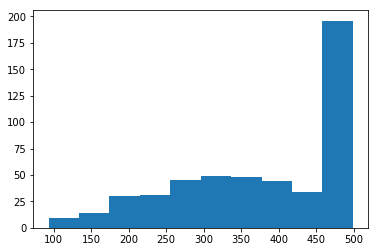

In [13]:
## test the model

from tqdm import tqdm_notebook
def model_policy(model, obs):
    obs_var = Variable(torch.from_numpy(obs.astype(np.float32))[None, ...]).cuda()
    prob = model(obs_var)
    action = model.output().data[0][0]
    return action

## test basic policy
all_rewards = []
for igame in tqdm_notebook(range(500)):
    obs = env.reset()
    game_rewards = 0
    for step in range(1000):
        action = model_policy(model, obs)
        obs, reward, done, info = env.step(action)
        if done: break
        game_rewards += reward
    all_rewards.append(game_rewards)
    
_ = plt.hist(all_rewards)

## Train - Method 3

Another method can be found in the [official tutorial](https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py)